In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Mounted at /content/drive


# load

In [2]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


     |████████████████████████████████| 2.5 MB 13.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185284 sha256=f45b2a72f3a991c958115a2914319160c4b6064ab6983efc5b8ea8d170a95c86
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 16.0 MB/s 
     |████████████████████████████████| 1.3 MB 14.2 MB/s 
     |████████████████████████████████| 1.6 MB 14.5 MB/s 
     |████████████████████████████████| 20.1 MB 101.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 r

#config

In [3]:

config = {
    "ALG": "NFiVAE_IRMStudent_Apr28",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BC"
config['METHOD'] = "iVAE_IRM"



if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 1500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 25000 # phase 2
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10
    config['BATCH_SIZE'] = 50000
    config['MODEL_TYPE'] = 'NFiVAE'
    config['SELECT_PARENTS'] = True
    config['PARENT_THRESHOLD'] = -1
   



config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

config['METHOD'] = "iVAE_IRM"



#testing/il

In [6]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent, NFiVAE_IRMStudent
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
from vae.nfivae_wrapper import NFiVAE_wrapper
  
from torch import nn

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


#NFiVAE

In [107]:
from numbers import Number

import numpy as np
import torch
from torch import distributions as dist
from torch import nn
from torch.nn import functional as F
from torch import autograd
import copy


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation='none', slope=.1, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                #print("c", c)
                #print("self.fc", self.fc[c])
                #print("h", h)
                #print("self.act_f", self._act_f[c])
                
                h = self._act_f[c](self.fc[c](h))
        return h


class Dist:
    def __init__(self):
        pass

    def sample(self, *args):
        pass

    def log_pdf(self, *args, **kwargs):
        pass


class Normal(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

    def log_pdf_full(self, x, mu, v):
        """
        compute the log-pdf of a normal distribution with full covariance
        v is a batch of "pseudo sqrt" of covariance matrices of shape (batch_size, d_latent, d_latent)
        mu is batch of means of shape (batch_size, d_latent)
        """
        batch_size, d = mu.size()
        cov = torch.einsum('bik,bjk->bij', v, v)  # compute batch cov from its "pseudo sqrt"
        assert cov.size() == (batch_size, d, d)
        inv_cov = torch.inverse(cov)  # works on batches
        c = d * torch.log(self.c)
        # matrix log det doesn't work on batches!
        _, logabsdets = self._batch_slogdet(cov)
        xmu = x - mu
        return -0.5 * (c + logabsdets + torch.einsum('bi,bij,bj->b', [xmu, inv_cov, xmu]))

    def _batch_slogdet(self, cov_batch: torch.Tensor):
        """
        compute the log of the absolute value of determinants for a batch of 2D matrices. Uses torch.slogdet
        this implementation is just a for loop, but that is what's suggested in torch forums
        gpu compatible
        """
        batch_size = cov_batch.size(0)
        signs = torch.empty(batch_size, requires_grad=False).to(self.device)
        logabsdets = torch.empty(batch_size, requires_grad=False).to(self.device)
        for i, cov in enumerate(cov_batch):
            signs[i], logabsdets[i] = torch.slogdet(cov)
        return signs, logabsdets


class Laplace(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.laplace.Laplace(torch.zeros(1).to(self.device), torch.ones(1).to(self.device) / np.sqrt(2))
        self.name = 'laplace'

    def sample(self, mu, b):
        eps = self._dist.sample(mu.size())
        scaled = eps.mul(b)
        return scaled.add(mu)

    def log_pdf(self, x, mu, b, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            mu, b = mu.view(param_shape), b.view(param_shape)
        lpdf = -torch.log(2 * b) - (x - mu).abs().div(b)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf


class Bernoulli(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.bernoulli.Bernoulli(0.5 * torch.ones(1).to(self.device))
        self.name = 'bernoulli'

    def sample(self, p):
        eps = self._dist.sample(p.size())
        return eps

    def log_pdf(self, x, f, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            f = f.view(param_shape)
        lpdf = x * torch.log(f) + (1 - x) * torch.log(1 - f)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf






class NFiVAE(nn.Module):
    def __init__(self, latent_dim, data_dim, aux_dim, prior=None, decoder=None, encoder=None,
                 n_layers=3, hidden_dim=50, activation='lrelu', slope=.1, device='cpu', anneal=False, 
                 NF_priors_output_dim=20, NF_priors_n_layers=3, NF_priors_hidden_dim=50, ):
        super().__init__()

        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.aux_dim = aux_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.activation = activation
        self.slope = slope
        self.anneal_params = anneal

        if prior is None:
            self.prior_dist = Normal(device=device)
        else:
            self.prior_dist = prior

        if decoder is None:
            self.decoder_dist = Normal(device=device)
        else:
            self.decoder_dist = decoder

        if encoder is None:
            self.encoder_dist = Normal(device=device)
        else:
            self.encoder_dist = encoder

        
        self.logl = MLP(aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        # decoder params
        self.f = MLP(latent_dim, data_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        self.decoder_var = .01 * torch.ones(1).to(device)
        # encoder params
        self.g = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                     device=device)
        self.logv = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                        device=device)

        self.device = device

        # prior_params
        self.prior_mean = torch.zeros(1).to(device)
        
        # 1.1 T_NN(x)
        self.T_NN_x = MLP(latent_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        # 1.2 lambda_NN(Y,E)
        self.lambda_NN_YE = MLP(aux_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        
        # 2. T_f(x) and lambda_f(Y,E) are in the second dot product term
          # 2.1 T_f(x) = concat([X, X^2]). This is data dependent, we will define it later during training/evaluation process
          # 2.2 lambda_f(Y,E)
        self.lambda_f_YE = MLP(aux_dim, 2*latent_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        #self.T_f_x = torch.hstack([z, z**2])



        self.apply(weights_init)

        self._training_hyperparams = [1., 1., 1., 1., 1]
        
        print("\n***** VAE wrapper created with NFiVAE *****\n")

    def encoder_params(self, x, u):
        xu = torch.cat((x, u), 1)
        g = self.g(xu)
        logv = self.logv(xu)
        return g, logv.exp()

    def decoder_params(self, s):
        f = self.f(s)
        return f, self.decoder_var

    def prior_params(self, z, u):
        T_NN_x = self.T_NN_x(z)
        lambda_NN_YE = self.lambda_NN_YE(u)
        T_f_x = torch.hstack([z, z**2])
        lambda_f_YE = self.lambda_f_YE(u)

        log_x_ye = torch.sum(T_NN_x * lambda_NN_YE, axis = 1) + torch.sum(T_f_x * lambda_f_YE, axis = 1)
        #p_x_ye = log_x_ye.exp()
        #grad = autograd.grad(p_x_ye, [z], create_graph=True)[0]

        return log_x_ye.exp()

    def forward(self, x, u):
        
        encoder_params = self.encoder_params(x, u)
        z = self.encoder_dist.sample(*encoder_params)
        decoder_params = self.decoder_params(z)
        prior_params = self.prior_params(z, u)
        #return decoder_params, encoder_params, z, prior_params
        return decoder_params, encoder_params, z, prior_params

    def prior_1st_derivative_matching(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            derivative_of_log_encoder = ( self.encoder_params(z_plus_new, u) - self.encoder_params(z_minus_new, u) ) / (2*dz)
            derivative_of_log_prior = ( self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u) ) / (2*dz)
            

            
            #sum_derivative += 0.5 * ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            sum_derivative += ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative
    
    def prior_2nd_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = z.detach() - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz
            
            sum_derivative += (self.prior_params(z_plus_new, u) - 2*self.prior_params(z, u) + self.prior_params(z_minus_new, u)) / dz / dz

        return sum_derivative
        

    def prior_1st_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            #print("z_plus_new", z_plus_new)
            #print("z_minus_new", z_minus_new)
            
            sum_derivative += 0.5* ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative





    def elbo(self, x, u):
        decoder_params, (g, v), z, prior_params = self.forward(x, u)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xu = self.encoder_dist.log_pdf(z, g, v)
        #log_pz_u = self.prior_dist.log_pdf(z, *prior_params)
        log_pz_u = torch.log(prior_params[1])
        
        #####
        #weight_norm = torch.tensor(0.).cuda()
        #for w in self.T_NN_x.parameters():
        #    weight_norm += w.norm().pow(2)    
        #for w in self.lambda_NN_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #####
        
        
        if self.anneal_params:
            a, b, c, d, N = self._training_hyperparams
            M = z.size(0)
            log_qz_tmp = self.encoder_dist.log_pdf(z.view(M, 1, self.latent_dim), g.view(1, M, self.latent_dim),
                                                   v.view(1, M, self.latent_dim), reduce=False)
            log_qz = torch.logsumexp(log_qz_tmp.sum(dim=-1), dim=1, keepdim=False) - np.log(M * N)
            log_qz_i = (torch.logsumexp(log_qz_tmp, dim=1, keepdim=False) - np.log(M * N)).sum(dim=-1)

            return (a * log_px_z - b * (log_qz_xu - log_qz) - c * (log_qz - log_qz_i) - d * (
                    log_qz_i - log_pz_u)).mean(), z

        else:
            print("part1 & 2 = ", (log_px_z + log_pz_u.detach() - log_qz_xu).mean().detach().cpu().numpy(), 
                                  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean().detach().cpu().numpy(),
                                  z.norm().detach().cpu().numpy() )
            #print("       part2 = ", (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean())
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() - self.prior_1st_derivative(z, u).mean() , z 
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean(),  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() -  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            
            


    def anneal(self, N, max_iter, it):
        thr = int(max_iter / 1.6)
        a = 0.5 / self.decoder_var.item()
        self._training_hyperparams[-1] = N
        self._training_hyperparams[0] = min(2 * a, a + a * it / thr)
        self._training_hyperparams[1] = max(1, a * .3 * (1 - it / thr))
        self._training_hyperparams[2] = min(1, it / thr)
        self._training_hyperparams[3] = max(1, a * .5 * (1 - it / thr))
        if it > thr:
            self.anneal_params = False


#NFiVAE-*wrapper*

In [108]:
import torch
import torch.optim as optim
from torch import autograd, nn
from tqdm import tqdm
from fcit import fcit
import pickle
import numpy as np
#from vae.ivae import iVAE
#from vae.nfivae import NFiVAE
from torch._C import dtype
import torch.nn.functional as F
import random 


class NFiVAE_wrapper:
    def __init__(
        self,
        buffer, 
        data_dim,
        action_dim,
        env_dim = 2,
        latent_dim = 8,
        activation = 'lrelu',
        n_layers = 3,
        hidden_dim = 32,
        lr = 1e-3,
        seed = 0,
        #max_iter = 7e4,
        use_a = True, 
        use_e = False,
        num_updates = 1000,
        ckpt_file = './vae/nfivae_ckpt.pt',
        pa_dict_file = './vae/nfivae_padict.pkl',
        model_type = 'NFiVAE',
        parents_threshold = 2,
        ):
      
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.state_dim = data_dim
        self.action_dim = action_dim 
        self.latent_dim = latent_dim

        self.buffer = buffer

        if use_a and use_e:
            aux_dim = action_dim + env_dim 
            print("use both actions and env as aux variables")
        elif use_e == False:
            aux_dim = action_dim
            print("use only actions as aux variable")
        
        if model_type == 'iVAE':
            self.model = iVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
        elif model_type == 'NFiVAE':
            self.model = NFiVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
            
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.1, patience=100, verbose=True)
        self.ckpt_file = ckpt_file
        self.pa_dict_file = pa_dict_file

        self.use_a = use_a 
        self.use_e = use_e

        self.env_dim = env_dim
        print("learning rate of NFiVAE in phase 1:", lr)
        
        self.parents_threshold = parents_threshold


    def train(self, num_updates = 10000):
        
        print("NFiVAE wrapper train buffer sample size = ", self.buffer.sample()['state'].shape)
        
        loss_list = []
        best_window_loss = np.inf
        best_window_loss_num = 0
        self.model.train()
        for update_index in (range(num_updates)):
            loss = self._update_vae_model()
            loss_list.append(loss.detach().cpu())
            
            #if np.mean(loss_list[-100:]) < best_window_loss:
            if loss < best_window_loss:
                #best_window_loss = np.mean(loss_list[-100:])
                best_window_loss = loss
                best_window_loss_num = update_index
                torch.save(self.model.state_dict(), self.ckpt_file)
            """
            if len(loss_list) > 150: # train at least 150 epochs
                if np.mean(loss_list[-100:]) > best_window_loss:
                    self.model.load_state_dict(torch.load(self.ckpt_file))
                    return loss_list
            """
        
            if update_index % 100 ==0:
                print('\repoch {}/{} \tloss: {}'.format(update_index, num_updates, loss), end="")
                #print(update_index, loss)
        #torch.save(self.model.state_dict(), self.ckpt_file)
        
        self.model.load_state_dict(torch.load(self.ckpt_file))
        
        print("best loss model loaded, stored at update #", best_window_loss_num, "with loss", best_window_loss.detach().cpu().numpy())
        
        return loss_list


    def _update_vae_model(self):
        samples = self.buffer.sample()

        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        self.optimizer.zero_grad()
        #elbo_VAE, elbo_SM, z_est = self.model.elbo(x, ae)
        elbo, z_est = self.model.elbo(x, ae)
        #elbo = elbo_VAE - elbo_SM
        elbo.mul(-1).backward() #loss.backward()
        
        self.optimizer.step()

        #return elbo_VAE.mul(-1)
        return elbo.mul(-1)
        


    def predict_latent(self, samples):
        self.model.eval()
        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        _, _, z, _ = self.model(x, ae)
        return z


    def _get_random_states(self, num_states):
        return torch.FloatTensor(num_states, self.in_dim).uniform_(-1, 1)








    ############################        phase 2.       #########################
    ############################        phase 2.       #########################
    ############################        phase 2.       #########################


    def phase2_sampled_data(self, n_samples = 1000):

        
        n_queries = n_samples // self.buffer.batch_size + 1
      
        actions = []
        states = []
        latents = []

        for i in range(n_queries):
            samples = self.buffer.sample()
            actions.append(samples['action'].reshape(-1,1))
            states.append(samples['state'])
            z = self.predict_latent(samples)
            latents.append(z.detach().cpu().numpy())

        actions = np.concatenate(np.vstack(actions))[:n_samples].reshape(-1,1).astype(int)
        states = np.concatenate((states), axis = 0)[:n_samples]
        latents = np.concatenate((latents), axis = 0)[:n_samples]

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        
        
        """
        samples = self.buffer.sample_all()
        actions = (samples['action'].reshape(-1,1)).astype(int)
        states = (samples['state'])
        z = self.predict_latent(samples)
        latents = (z.detach().cpu().numpy())

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        """

        return states, latents, actions

        
    def phase2_find_parents(self, latents, actions):

        parents = []

        num_vars = latents.shape[1]

        for i in range(num_vars-1):
            for j in range(i+1, num_vars):
                pval_d = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1))
                pval_i = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1), actions)
                if pval_d < pval_i:
                    print('{} and {} are independent with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                else:
                    print('{} and {} are DEPENDENT with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                    parents.append(i)
                    parents.append(j)

        parents_set = set(parents)

        parents_dict = {}
        for p in parents_set:
            parents_dict[p] = parents.count(p)
            
        for i in range(num_vars):
            if i not in parents_set:
                parents_dict[i] = 0

        parents_dict_sorted = {}
        for w in sorted(parents_dict, key=parents_dict.get, reverse=True):
            print(w, parents_dict[w])
            if parents_dict[w]>self.parents_threshold:
                parents_dict_sorted[w] = parents_dict[w]

        return list(parents_dict_sorted.keys()), parents_dict_sorted


    def start_phase2(self, n_samples = 50000, save = True):

        print("\n***** Starts Phase 2 *****")
        
        #n_samples = self.buffer.sample_all()['state'].shape[0] * 2
        
        print("phase 2: n_samples = ", n_samples)
        
        states, latents, actions = self.phase2_sampled_data(n_samples)
        pa_list, pa_dict = self.phase2_find_parents(latents, actions)

        self.pa_list = sorted(pa_list)
        self.pa_dict = pa_dict 
        
        print("parent list:", self.pa_list)

        if save:
            pickle.dump(self.pa_dict, open(self.pa_dict_file, "wb"))

        return pa_list, pa_dict


    
    

# tests

In [15]:
traj_num = 5

config["NUM_TRAJS_GIVEN"] = traj_num
config["TRAJ_SHIFT"] = traj_num


config['ALG'] = "May1_phase1test2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


###############.  settings   ###############

#if config['METHOD'] == 'iVAE_IRM':


all_results_trail = []


trail = 0

config['TRIAL'] = trail 

print("batch size = ", config['BATCH_SIZE'])


###############.  start a trail   ###############

config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
print("Config: %s" % config)

TRIAL = config["TRIAL"] #args.trial
print("Trial number %s" % TRIAL)

results_dir_base = "testing/results/"
results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
results_file_path = os.path.join(results_dir, results_file_name)

if os.path.exists(os.path.join(results_dir, config_file)):
    raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




###############.  10 runs for each trail   ###############

print("config method = ", config['METHOD'])
print("config env = ", config['ENV'])

run_seed = 0

batch size =  50000
Config: {'ALG': 'May1_phase1test2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 7}
Trial number 0


NameError: ignored

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  7
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -234.15903 -0.065635875
epoch 0/1500 	loss: 234.15902709960938part1 & 2 =  -232.07784 -0.10449472
part1 & 2 =  -213.53918 -0.13542148
part1 & 2 =  -198.97205 -0.2082406
part1 & 2 =  -190.21495 -0.21051423
part1 & 2 =  -183.44409 -0.2906936
part1 & 2 =  -168.40103 -0.32147142
part1 & 2 =  -161.33516 -0.39985627
part1 & 2 =  -154.46866 -0.4934607
part1 & 2 =  -145.35278 -0.41092926
part1 & 2 =  -137.98218 -0.5486948
part1 & 2 =  -131.62706 -0.59489137
part1 & 2 =  -121.45851 -0.62815565
part1 & 2 =  -120.165085 -0.6230617
part1 & 2 =  -111.8159 -1.1225668
part1 & 2 =  -110.54225 -1.0398219
part1 & 2 =  -103.63931 -0.8955945
part1 & 2 =  -100.426094 -1.1335027
part1 & 2 =  -93.425934 -0.8055814
part1 & 2 =  -89.670654 -1.3318288
part1 & 2 =

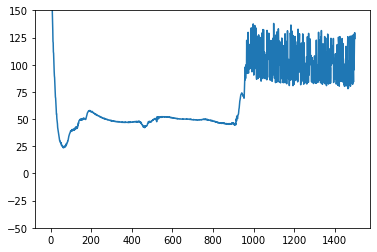

In [92]:
env = gym.make(config["ENV"])
trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
action_dim = env.action_space.n
num_training_envs = config["NUM_TRAINING_ENVS"]

# run_seed = run_seed
batch_size = config["BATCH_SIZE"]
teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
teacher.load_pretrained()

buffer = fill_buffer(
    trajs_path=teacher.trajs_paths,
    batch_size=batch_size,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

if buffer.total_size < batch_size:
    batch_size = buffer.total_size



##########################      COMMON      ##########################

print("state_dim", state_dim)

causal_features_encoder = FeaturesEncoder(
    input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
)

policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])




##########################       iVAE IRM       #######################


print("\n ***** Start Phase 1 ***** \n")

config['LATENT_DIM'] = state_dim  -1 # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

print("latent dim = ", config['LATENT_DIM'] )


ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                            use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])

loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

import matplotlib.pyplot as plt
plt.plot((np.array(loss_list)))
plt.ylim(-50,150)
plt.show()



# make student

In [5]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])



    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':


        print("\n ***** Start Phase 1 ***** \n")

        config['LATENT_DIM'] = state_dim  #-1 # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

        print("latent dim = ", config['LATENT_DIM'] )


        ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
        pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

        vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                                   use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])
 
        loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot((np.array(loss_list)))
        plt.yscale("log")
        #plt.ylim(-50,150)
        plt.show()


        plt.figure()
        plt.plot((np.array(loss_list)))
        #plt.yscale("log")
        plt.ylim(-50,150)
        plt.show()




        ########################################

        print("\n ***** Start Phase 2 ***** \n")
        if config['SELECT_PARENTS'] == True:
            vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        else:
            vae_wrapper.pa_list = [0,1,2,3,4,5,6,7] #, 8, 9, 10, 11]
        
        policy_network = StudentNetwork(in_dim=len(vae_wrapper.pa_list), out_dim=action_dim, width=config["MLP_WIDTHS"])
        
        #phase3_obs_to_latent_encoder = Phase3ObstoLatentEncoder(obs_size = state_dim, latent_size = len(vae_wrapper.pa_list))
            #input_size=state_dim, representation_size=len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"] )
        
        
        return NFiVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            #phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


#10 Trails -- iVAE IRM 5 traj_num loss [threshold = -1]

In [15]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

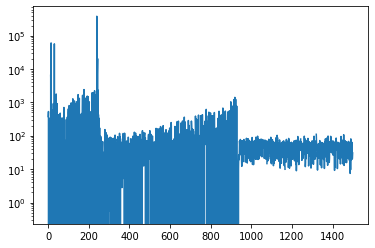

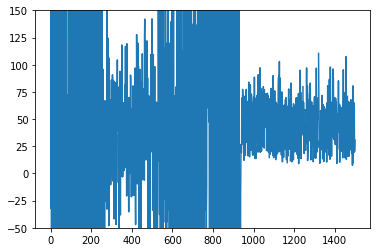


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:04<02:35,  1.61s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:32,  1.63s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:24,  1.61s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.62s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:30<02:13,  1.65s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:13,  1.66s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:11,  1.66s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:05,  1.66s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:05,  1.67s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:56,  1.62s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:51,  1.61s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:50,  1.62s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:03<01:39,  1.64s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:37,  1.63s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:06<01:36,  1.63s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:08<01:35,  1.64s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.66s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:11<01:33,  1.67s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:28,  1.64s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:19<01:22,  1.63s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:23<01:19,  1.63s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:26<01:15,  1.62s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:31<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:34<01:09,  1.65s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:37<01:05,  1.63s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:02,  1.65s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:42<01:01,  1.66s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:47<00:55,  1.64s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:49<00:54,  1.64s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:57<00:45,  1.61s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:02<00:40,  1.64s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:04<00:39,  1.65s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:05<00:37,  1.64s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:12<00:30,  1.62s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:15<00:27,  1.64s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:28<00:14,  1.61s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:31<00:11,  1.62s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:38<00:04,  1.61s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:40<00:03,  1.61s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:41<00:01,  1.61s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:43<00:00,  1.60s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [16]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [17]:
policy_loss_list_neg1 = policy_loss_list

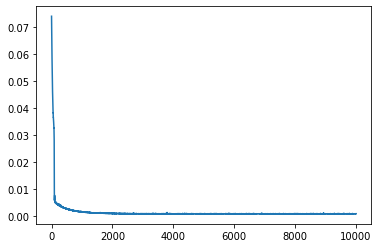

In [19]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1)

In [20]:
with open('policy_loss_list_neg1.npy', 'wb') as f:
    np.save(f, policy_loss_list_neg1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 0]

In [22]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 0

batch size =  50000
Config: {'ALG': 'May1_test1_th0_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

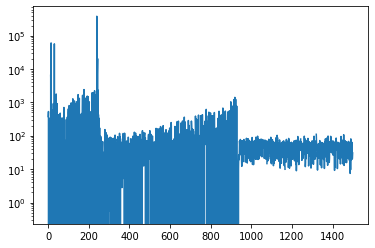

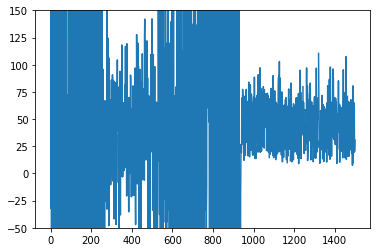


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:48,  1.72s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:05<02:43,  1.69s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:40,  1.67s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:34,  1.64s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:26,  1.63s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.63s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:15,  1.64s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.62s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:11,  1.64s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:09,  1.64s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:03,  1.62s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:02,  1.64s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.64s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:59,  1.66s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:55,  1.68s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:54,  1.68s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:47,  1.66s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:59<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:04<01:41,  1.67s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:39,  1.65s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:09<01:35,  1.65s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.65s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:12<01:32,  1.65s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:14<01:31,  1.67s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:30,  1.68s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:17<01:28,  1.66s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:19<01:26,  1.66s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:20<01:24,  1.67s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:22<01:25,  1.71s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:24<01:22,  1.68s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:25<01:19,  1.65s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:27<01:18,  1.67s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:29<01:15,  1.65s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:30<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:32<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.63s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:35<01:08,  1.62s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:37<01:06,  1.61s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:40<01:02,  1.61s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:00,  1.61s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:45<00:58,  1.64s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:48<00:55,  1.63s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:50<00:53,  1.63s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:53<00:50,  1.64s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:55<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:58<00:45,  1.64s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [02:00<00:44,  1.66s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:03<00:41,  1.67s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:05<00:39,  1.66s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:08<00:35,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.63s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:11<00:32,  1.62s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:13<00:31,  1.63s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:29,  1.66s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:16<00:28,  1.68s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:18<00:26,  1.66s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:19<00:24,  1.66s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:21<00:23,  1.66s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:23<00:21,  1.65s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:24<00:19,  1.65s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:26<00:18,  1.67s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:28<00:16,  1.67s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:29<00:14,  1.67s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:31<00:13,  1.68s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:33<00:11,  1.67s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:34<00:09,  1.67s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:36<00:08,  1.66s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:38<00:06,  1.65s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:39<00:04,  1.64s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:41<00:03,  1.65s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:43<00:01,  1.66s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:44<00:00,  1.67s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [23]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th0_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        #for run_seed in range(config["NUM_REPETITIONS"]):
        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [24]:
policy_loss_list_0 = policy_loss_list

In [25]:
with open('policy_loss_list_0.npy', 'wb') as f:
    np.save(f, policy_loss_list_0)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 1]

In [26]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 1

batch size =  50000
Config: {'ALG': 'May1_test1_th1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

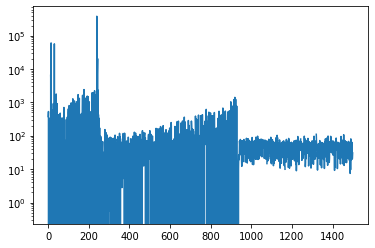

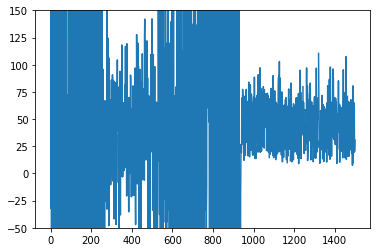


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 173.48468151688576


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 147.72795072197914


  3%|▎         | 3/100 [00:04<02:37,  1.62s/it]

2 146.03174817562103


  4%|▍         | 4/100 [00:06<02:35,  1.62s/it]

3 144.6511772274971


  5%|▌         | 5/100 [00:08<02:33,  1.62s/it]

4 144.21071165800095


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

5 143.9515316784382


  7%|▋         | 7/100 [00:11<02:29,  1.60s/it]

6 143.39084860682487


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 143.4088019132614


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 143.22464799880981


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 143.04051831364632


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 142.87224128842354


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 142.85448510944843


 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]

12 142.95822994410992


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 142.8875399082899


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 142.72742387652397


 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]

15 142.66595178842545


 17%|█▋        | 17/100 [00:27<02:16,  1.64s/it]

16 142.67981265485287


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 142.5779106914997


 19%|█▉        | 19/100 [00:30<02:12,  1.63s/it]

18 142.53466802835464


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 142.32784405350685


 21%|██        | 21/100 [00:34<02:07,  1.62s/it]

20 142.48350608348846


 22%|██▏       | 22/100 [00:35<02:09,  1.65s/it]

21 142.3737137913704


 23%|██▎       | 23/100 [00:37<02:11,  1.71s/it]

22 142.2871055006981


 24%|██▍       | 24/100 [00:39<02:07,  1.68s/it]

23 142.2011902332306


 25%|██▌       | 25/100 [00:40<02:04,  1.66s/it]

24 142.29973801970482


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 142.2851139307022


 27%|██▋       | 27/100 [00:44<02:00,  1.65s/it]

26 142.15067201852798


 28%|██▊       | 28/100 [00:45<01:58,  1.65s/it]

27 142.26092115044594


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 142.19534794986248


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 142.336190238595


 31%|███       | 31/100 [00:50<01:54,  1.66s/it]

30 142.1312538087368


 32%|███▏      | 32/100 [00:52<01:53,  1.67s/it]

31 142.04886239767075


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 142.17832800745964


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 142.1948668062687


 35%|███▌      | 35/100 [00:57<01:48,  1.66s/it]

34 141.94075210392475


 36%|███▌      | 36/100 [00:59<01:47,  1.68s/it]

35 141.98756954073906


 37%|███▋      | 37/100 [01:00<01:44,  1.65s/it]

36 141.99865865707397


 38%|███▊      | 38/100 [01:02<01:41,  1.64s/it]

37 141.96826921403408


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 142.06269040703773


 40%|████      | 40/100 [01:05<01:38,  1.63s/it]

39 142.05796533823013


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 141.90473027527332


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 141.9539389014244


 43%|████▎     | 43/100 [01:10<01:33,  1.64s/it]

42 141.91789485514164


 44%|████▍     | 44/100 [01:12<01:30,  1.62s/it]

43 141.97578336298466


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 141.95500844717026


 46%|████▌     | 46/100 [01:15<01:27,  1.62s/it]

45 141.83824172616005


 47%|████▋     | 47/100 [01:16<01:25,  1.62s/it]

46 141.87401585280895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 141.84159994125366


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 141.83182632923126


 50%|█████     | 50/100 [01:21<01:20,  1.62s/it]

49 141.8903431892395


 51%|█████     | 51/100 [01:23<01:19,  1.62s/it]

50 141.9774239808321


 52%|█████▏    | 52/100 [01:25<01:17,  1.62s/it]

51 141.92585642635822


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 141.90286365151405


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 141.6527271270752


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 141.72266256809235


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 141.81636033952236


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 141.80914497375488


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 141.81816405057907


 59%|█████▉    | 59/100 [01:36<01:06,  1.61s/it]

58 141.8234865218401


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 141.7881373167038


 61%|██████    | 61/100 [01:39<01:04,  1.65s/it]

60 141.7731975018978


 62%|██████▏   | 62/100 [01:41<01:03,  1.66s/it]

61 141.8017753660679


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 141.68875554203987


 64%|██████▍   | 64/100 [01:44<00:59,  1.64s/it]

63 141.75734663009644


 65%|██████▌   | 65/100 [01:46<00:57,  1.63s/it]

64 141.89097732305527


 66%|██████▌   | 66/100 [01:48<00:56,  1.65s/it]

65 141.6288635134697


 67%|██████▋   | 67/100 [01:49<00:55,  1.67s/it]

66 141.659940674901


 68%|██████▊   | 68/100 [01:51<00:53,  1.67s/it]

67 141.72191351652145


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 141.76373142004013


 70%|███████   | 70/100 [01:54<00:49,  1.66s/it]

69 141.86020997166634


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 141.68974283337593


 72%|███████▏  | 72/100 [01:57<00:46,  1.66s/it]

71 141.8311131298542


 73%|███████▎  | 73/100 [01:59<00:45,  1.67s/it]

72 141.76859322190285


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 141.74418288469315


 75%|███████▌  | 75/100 [02:02<00:41,  1.65s/it]

74 141.72872853279114


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 141.7132216244936


 77%|███████▋  | 77/100 [02:06<00:37,  1.62s/it]

76 141.65201944112778


 78%|███████▊  | 78/100 [02:07<00:35,  1.63s/it]

77 141.69405549764633


 79%|███████▉  | 79/100 [02:09<00:34,  1.62s/it]

78 141.75324311852455


 80%|████████  | 80/100 [02:11<00:32,  1.65s/it]

79 141.70046338438988


 81%|████████  | 81/100 [02:12<00:31,  1.65s/it]

80 141.55046227574348


 82%|████████▏ | 82/100 [02:14<00:29,  1.63s/it]

81 141.77949894964695


 83%|████████▎ | 83/100 [02:15<00:27,  1.63s/it]

82 141.69786716997623


 84%|████████▍ | 84/100 [02:17<00:26,  1.64s/it]

83 141.73595371842384


 85%|████████▌ | 85/100 [02:19<00:24,  1.64s/it]

84 141.67204120755196


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 141.70084902644157


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 141.7158525288105


 88%|████████▊ | 88/100 [02:24<00:19,  1.64s/it]

87 141.6074246764183


 89%|████████▉ | 89/100 [02:25<00:17,  1.64s/it]

88 141.6108176857233


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 141.6674730181694


 91%|█████████ | 91/100 [02:29<00:14,  1.63s/it]

90 141.7377314865589


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 141.60641238093376


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 141.66148880124092


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 141.55813911557198


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 141.65882486104965


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 141.46812435984612


 97%|█████████▋| 97/100 [02:38<00:04,  1.62s/it]

96 141.68223389983177


 98%|█████████▊| 98/100 [02:40<00:03,  1.63s/it]

97 141.5583133995533


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 141.57174889743328


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 141.65230774879456

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.073660708963871	

epoch 9000/10000, policy loss 0.0010546579724177718	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [27]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [28]:
policy_loss_list_1 = policy_loss_list

In [29]:
with open('policy_loss_list_1.npy', 'wb') as f:
    np.save(f, policy_loss_list_1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 2]

In [30]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 2

batch size =  50000
Config: {'ALG': 'May1_test1_th2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 2, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

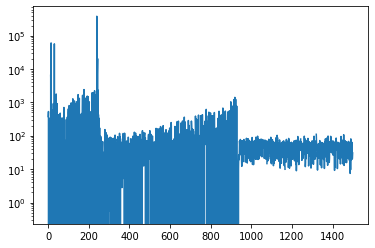

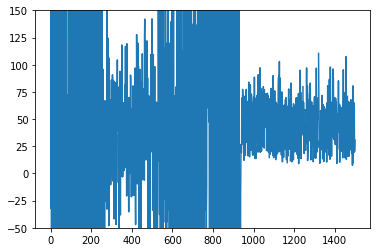


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:42,  1.65s/it]

0 223.2892910838127


  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]

1 190.86424526572227


  3%|▎         | 3/100 [00:04<02:40,  1.66s/it]

2 189.83276018500328


  4%|▍         | 4/100 [00:06<02:37,  1.65s/it]

3 188.45459845662117


  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

4 187.85277324914932


  6%|▌         | 6/100 [00:09<02:33,  1.63s/it]

5 187.7192989885807


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 187.34361284971237


  8%|▊         | 8/100 [00:13<02:28,  1.62s/it]

7 187.30750381946564


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 186.8571950495243


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 187.09012207388878


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 186.63316264748573


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 186.71074962615967


 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]

12 186.7717032134533


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 186.7928744852543


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 186.49444988369942


 16%|█▌        | 16/100 [00:26<02:16,  1.62s/it]

15 186.56471702456474


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 186.51241973042488


 18%|█▊        | 18/100 [00:29<02:11,  1.61s/it]

17 186.40492498874664


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 186.3739876449108


 20%|██        | 20/100 [00:32<02:11,  1.65s/it]

19 186.13015151023865


 21%|██        | 21/100 [00:34<02:10,  1.65s/it]

20 186.4420903623104


 22%|██▏       | 22/100 [00:35<02:08,  1.65s/it]

21 186.01797914505005


 23%|██▎       | 23/100 [00:37<02:06,  1.64s/it]

22 186.1226080954075


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 186.00765866041183


 25%|██▌       | 25/100 [00:40<02:03,  1.64s/it]

24 185.90693926811218


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 186.01365131139755


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 185.87429150938988


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 185.91071313619614


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 185.89232182502747


 30%|███       | 30/100 [00:49<01:54,  1.64s/it]

29 186.1568884253502


 31%|███       | 31/100 [00:50<01:52,  1.64s/it]

30 185.88049280643463


 32%|███▏      | 32/100 [00:52<01:52,  1.65s/it]

31 185.7849758565426


 33%|███▎      | 33/100 [00:53<01:50,  1.65s/it]

32 185.96425804495811


 34%|███▍      | 34/100 [00:55<01:48,  1.64s/it]

33 185.98745784163475


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 185.72625583410263


 36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

35 185.77708917856216


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 185.8945066332817


 38%|███▊      | 38/100 [01:02<01:40,  1.62s/it]

37 185.63016599416733


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 185.92640191316605


 40%|████      | 40/100 [01:05<01:38,  1.65s/it]

39 185.7859444618225


 41%|████      | 41/100 [01:07<01:37,  1.65s/it]

40 185.65180572867393


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 185.64221921563148


 43%|████▎     | 43/100 [01:10<01:33,  1.63s/it]

42 185.5505010187626


 44%|████▍     | 44/100 [01:11<01:31,  1.64s/it]

43 185.6212317943573


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 185.64851582050323


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 185.57081761956215


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 185.48350685834885


 48%|████▊     | 48/100 [01:18<01:24,  1.62s/it]

47 185.5927678644657


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 185.6034722328186


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 185.54561886191368


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 185.7311596274376


 52%|█████▏    | 52/100 [01:24<01:18,  1.64s/it]

51 185.6763395667076


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 185.55066591501236


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 185.34095266461372


 55%|█████▌    | 55/100 [01:29<01:12,  1.62s/it]

54 185.55099207162857


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 185.47304672002792


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 185.29896929860115


 58%|█████▊    | 58/100 [01:34<01:08,  1.63s/it]

57 185.5480798780918


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 185.42377680540085


 60%|██████    | 60/100 [01:37<01:05,  1.64s/it]

59 185.4587526023388


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 185.31228232383728


 62%|██████▏   | 62/100 [01:41<01:02,  1.64s/it]

61 185.43431475758553


 63%|██████▎   | 63/100 [01:42<01:00,  1.64s/it]

62 185.3770859837532


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 185.36181235313416


 65%|██████▌   | 65/100 [01:46<00:58,  1.66s/it]

64 185.4603129029274


 66%|██████▌   | 66/100 [01:47<00:56,  1.66s/it]

65 185.07617008686066


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 185.39790657162666


 68%|██████▊   | 68/100 [01:51<00:52,  1.64s/it]

67 185.27060124278069


 69%|██████▉   | 69/100 [01:52<00:50,  1.63s/it]

68 185.31933906674385


 70%|███████   | 70/100 [01:54<00:49,  1.65s/it]

69 185.4543222784996


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 185.37445494532585


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 185.4899162054062


 73%|███████▎  | 73/100 [01:59<00:43,  1.62s/it]

72 185.4009444117546


 74%|███████▍  | 74/100 [02:00<00:41,  1.61s/it]

73 185.11696791648865


 75%|███████▌  | 75/100 [02:02<00:40,  1.61s/it]

74 185.41752728819847


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 185.36312049627304


 77%|███████▋  | 77/100 [02:05<00:36,  1.61s/it]

76 185.33598411083221


 78%|███████▊  | 78/100 [02:07<00:35,  1.61s/it]

77 185.26896691322327


 79%|███████▉  | 79/100 [02:08<00:33,  1.60s/it]

78 185.46326300501823


 80%|████████  | 80/100 [02:10<00:32,  1.60s/it]

79 185.32718542218208


 81%|████████  | 81/100 [02:12<00:30,  1.59s/it]

80 185.1139039993286


 82%|████████▏ | 82/100 [02:13<00:28,  1.60s/it]

81 185.49988582730293


 83%|████████▎ | 83/100 [02:15<00:27,  1.60s/it]

82 185.17612195014954


 84%|████████▍ | 84/100 [02:16<00:25,  1.62s/it]

83 185.19824868440628


 85%|████████▌ | 85/100 [02:18<00:24,  1.61s/it]

84 185.30785992741585


 86%|████████▌ | 86/100 [02:20<00:22,  1.60s/it]

85 185.16383001208305


 87%|████████▋ | 87/100 [02:21<00:20,  1.61s/it]

86 185.29975670576096


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 185.16308107972145


 89%|████████▉ | 89/100 [02:25<00:18,  1.65s/it]

88 185.33415803313255


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 185.27692666649818


 91%|█████████ | 91/100 [02:28<00:14,  1.65s/it]

90 185.21141001582146


 92%|█████████▏| 92/100 [02:29<00:13,  1.63s/it]

91 185.26757860183716


 93%|█████████▎| 93/100 [02:31<00:11,  1.64s/it]

92 185.17595487833023


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 185.33630123734474


 95%|█████████▌| 95/100 [02:34<00:08,  1.65s/it]

94 185.17711699008942


 96%|█████████▌| 96/100 [02:36<00:06,  1.64s/it]

95 184.93442958593369


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 185.20353704690933


 98%|█████████▊| 98/100 [02:39<00:03,  1.62s/it]

97 185.35120877623558


 99%|█████████▉| 99/100 [02:41<00:01,  1.62s/it]

98 185.07706689834595


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 185.36947363615036

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07309768348932266	

epoch 9000/10000, policy loss 0.0011201589368283749	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [31]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [32]:
policy_loss_list_2 = policy_loss_list

In [33]:
with open('policy_loss_list_2.npy', 'wb') as f:
    np.save(f, policy_loss_list_2)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 3]

In [34]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 3

batch size =  50000
Config: {'ALG': 'May1_test1_th3_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 3, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

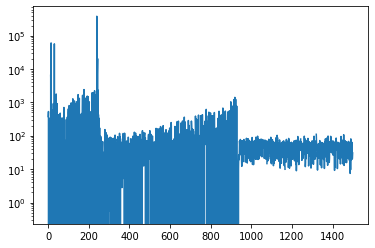

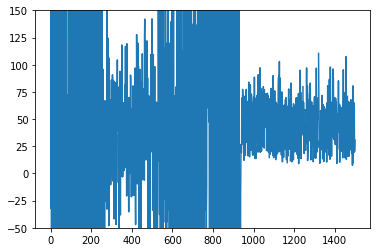


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:46,  1.68s/it]

0 331.1370737552643


  2%|▏         | 2/100 [00:03<02:43,  1.67s/it]

1 280.2598352730274


  3%|▎         | 3/100 [00:04<02:41,  1.67s/it]

2 278.9625595808029


  4%|▍         | 4/100 [00:06<02:38,  1.65s/it]

3 277.5366276204586


  5%|▌         | 5/100 [00:08<02:36,  1.65s/it]

4 276.2170387804508


  6%|▌         | 6/100 [00:09<02:33,  1.64s/it]

5 275.9663231372833


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

6 276.14849931001663


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 275.5466256439686


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 275.5074882209301


 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

9 275.4225805103779


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 274.99415904283524


 12%|█▏        | 12/100 [00:19<02:21,  1.60s/it]

11 274.98768001794815


 13%|█▎        | 13/100 [00:21<02:19,  1.60s/it]

12 274.98843336105347


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 275.1361231505871


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 274.80184730887413


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 274.85611858963966


 17%|█▋        | 17/100 [00:27<02:15,  1.63s/it]

16 274.4100962281227


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 274.7122690975666


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 274.44699984788895


 20%|██        | 20/100 [00:32<02:12,  1.65s/it]

19 274.2395139336586


 21%|██        | 21/100 [00:34<02:11,  1.67s/it]

20 274.63301825523376


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 274.45681950449944


 23%|██▎       | 23/100 [00:37<02:06,  1.65s/it]

22 274.29103350639343


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 274.08579114079475


 25%|██▌       | 25/100 [00:40<02:03,  1.65s/it]

24 274.02194422483444


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 274.3318381309509


 27%|██▋       | 27/100 [00:44<01:58,  1.62s/it]

26 273.83103758096695


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 274.17993798851967


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 274.23418962955475


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 274.1642828285694


 31%|███       | 31/100 [00:50<01:52,  1.63s/it]

30 273.70837876200676


 32%|███▏      | 32/100 [00:52<01:51,  1.64s/it]

31 273.87390729784966


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 273.8703398704529


 34%|███▍      | 34/100 [00:55<01:48,  1.65s/it]

33 274.16256657242775


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 273.423868060112


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 274.00400826334953


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 273.85234636068344


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 273.5247763991356


 39%|███▉      | 39/100 [01:03<01:41,  1.66s/it]

38 273.91088250279427


 40%|████      | 40/100 [01:05<01:39,  1.66s/it]

39 273.7802450656891


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 273.4092101752758


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 273.8441425859928


 43%|████▎     | 43/100 [01:10<01:32,  1.63s/it]

42 273.5028932392597


 44%|████▍     | 44/100 [01:11<01:32,  1.64s/it]

43 273.2845428586006


 45%|████▌     | 45/100 [01:13<01:30,  1.65s/it]

44 273.3468194901943


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 273.4767259955406


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 273.4473971426487


 48%|████▊     | 48/100 [01:18<01:25,  1.65s/it]

47 273.57755744457245


 49%|████▉     | 49/100 [01:20<01:23,  1.63s/it]

48 273.49204018712044


 50%|█████     | 50/100 [01:21<01:21,  1.64s/it]

49 273.3232891857624


 51%|█████     | 51/100 [01:23<01:20,  1.65s/it]

50 273.61479690670967


 52%|█████▏    | 52/100 [01:25<01:18,  1.64s/it]

51 273.7128612399101


 53%|█████▎    | 53/100 [01:26<01:16,  1.64s/it]

52 273.6814542710781


 54%|█████▍    | 54/100 [01:28<01:15,  1.65s/it]

53 273.1243350505829


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 273.3565848171711


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 273.6353197991848


 57%|█████▋    | 57/100 [01:33<01:09,  1.62s/it]

56 273.112540602684


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 273.2410719692707


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 273.5548580288887


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 273.191652148962


 61%|██████    | 61/100 [01:39<01:04,  1.64s/it]

60 273.25413849949837


 62%|██████▏   | 62/100 [01:41<01:02,  1.63s/it]

61 273.356076836586


 63%|██████▎   | 63/100 [01:43<01:00,  1.65s/it]

62 273.4614462554455


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 273.3745560348034


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 272.99108216166496


 66%|██████▌   | 66/100 [01:48<00:56,  1.66s/it]

65 273.018123537302


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 273.21648198366165


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 272.97126868367195


 69%|██████▉   | 69/100 [01:52<00:50,  1.64s/it]

68 273.2804522514343


 70%|███████   | 70/100 [01:54<00:49,  1.63s/it]

69 273.20512250065804


 71%|███████   | 71/100 [01:56<00:46,  1.62s/it]

70 273.3050141632557


 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/it]

71 273.2083608210087


 73%|███████▎  | 73/100 [01:59<00:44,  1.63s/it]

72 273.1368930339813


 74%|███████▍  | 74/100 [02:01<00:42,  1.63s/it]

73 273.24853533506393


 75%|███████▌  | 75/100 [02:02<00:41,  1.64s/it]

74 273.34189823269844


 76%|███████▌  | 76/100 [02:04<00:39,  1.66s/it]

75 273.04744005203247


 77%|███████▋  | 77/100 [02:06<00:37,  1.64s/it]

76 272.93242159485817


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 272.8865285217762


 79%|███████▉  | 79/100 [02:09<00:34,  1.66s/it]

78 273.3119262754917


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 273.1531668007374


 81%|████████  | 81/100 [02:12<00:31,  1.67s/it]

80 272.8070638179779


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 273.27856838703156


 83%|████████▎ | 83/100 [02:16<00:28,  1.66s/it]

82 273.20801573991776


 84%|████████▍ | 84/100 [02:17<00:26,  1.68s/it]

83 272.92715069651604


 85%|████████▌ | 85/100 [02:19<00:25,  1.67s/it]

84 273.00831389427185


 86%|████████▌ | 86/100 [02:20<00:23,  1.64s/it]

85 272.95148089528084


 87%|████████▋ | 87/100 [02:22<00:21,  1.64s/it]

86 273.42742761969566


 88%|████████▊ | 88/100 [02:24<00:19,  1.63s/it]

87 272.7301535010338


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 273.3336791098118


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 273.0287007987499


 91%|█████████ | 91/100 [02:29<00:14,  1.61s/it]

90 273.2448498606682


 92%|█████████▏| 92/100 [02:30<00:12,  1.61s/it]

91 273.0912160873413


 93%|█████████▎| 93/100 [02:32<00:11,  1.61s/it]

92 272.88679111003876


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 273.2870182096958


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 272.88769924640656


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 272.6806816458702


 97%|█████████▋| 97/100 [02:38<00:04,  1.64s/it]

96 272.9183651506901


 98%|█████████▊| 98/100 [02:40<00:03,  1.62s/it]

97 272.9765895307064


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 272.68312284350395


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 273.04564675688744

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.5826263427734375	

epoch 9000/10000, policy loss 0.001883620978333056	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [35]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th3_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [36]:
policy_loss_list_3 = policy_loss_list

In [37]:
with open('policy_loss_list_3.npy', 'wb') as f:
    np.save(f, policy_loss_list_3)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 4]

In [38]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 4

batch size =  50000
Config: {'ALG': 'May1_test1_th4_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 4, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

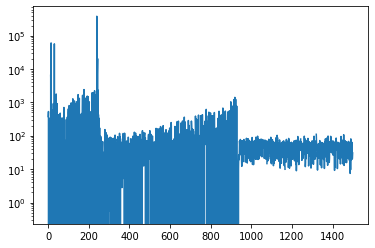

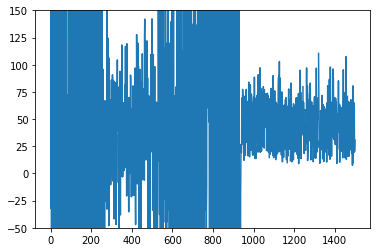


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 458.14095240831375


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 385.53909945487976


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 382.1601721048355


  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

3 380.2224694490433


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 379.5685480237007


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 378.52447777986526


  7%|▋         | 7/100 [00:11<02:30,  1.61s/it]

6 378.4989966750145


  8%|▊         | 8/100 [00:12<02:28,  1.61s/it]

7 377.95162189006805


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 377.735186457634


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 377.8160279393196


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 377.1444729566574


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 376.85272789001465


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 377.10765236616135


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 377.159645318985


 15%|█▌        | 15/100 [00:24<02:17,  1.61s/it]

14 376.75308805704117


 16%|█▌        | 16/100 [00:25<02:15,  1.62s/it]

15 376.94828975200653


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 376.78533178567886


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 376.730981528759


 19%|█▉        | 19/100 [00:30<02:11,  1.63s/it]

18 376.724601149559


 20%|██        | 20/100 [00:32<02:09,  1.62s/it]

19 376.32525008916855


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 376.78580194711685


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 376.3378132581711


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 376.5279993414879


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 376.0284957885742


 25%|██▌       | 25/100 [00:40<02:02,  1.63s/it]

24 375.9956703186035


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 376.22467935085297


 27%|██▋       | 27/100 [00:43<01:58,  1.63s/it]

26 375.7737295627594


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 375.99238216876984


 29%|██▉       | 29/100 [00:47<01:55,  1.63s/it]

28 376.12437492609024


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 376.42395532131195


 31%|███       | 31/100 [00:50<01:51,  1.62s/it]

30 375.82136833667755


 32%|███▏      | 32/100 [00:51<01:50,  1.62s/it]

31 375.7602673172951


 33%|███▎      | 33/100 [00:53<01:50,  1.64s/it]

32 376.07972556352615


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 376.10817378759384


 35%|███▌      | 35/100 [00:56<01:46,  1.63s/it]

34 375.3499831557274


 36%|███▌      | 36/100 [00:58<01:45,  1.64s/it]

35 376.005636036396


 37%|███▋      | 37/100 [01:00<01:43,  1.64s/it]

36 375.83478885889053


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 374.99941688776016


 39%|███▉      | 39/100 [01:03<01:39,  1.62s/it]

38 376.43352872133255


 40%|████      | 40/100 [01:04<01:37,  1.62s/it]

39 375.50174218416214


 41%|████      | 41/100 [01:06<01:34,  1.61s/it]

40 375.508504986763


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 375.7503463625908


 43%|████▎     | 43/100 [01:09<01:32,  1.63s/it]

42 375.54787516593933


 44%|████▍     | 44/100 [01:11<01:30,  1.62s/it]

43 375.0511623620987


 45%|████▌     | 45/100 [01:12<01:28,  1.61s/it]

44 375.8259227871895


 46%|████▌     | 46/100 [01:14<01:28,  1.63s/it]

45 375.4002010822296


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 375.19975984096527


 48%|████▊     | 48/100 [01:17<01:25,  1.63s/it]

47 375.29962438344955


 49%|████▉     | 49/100 [01:19<01:23,  1.64s/it]

48 375.3646755218506


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 375.53023594617844


 51%|█████     | 51/100 [01:22<01:19,  1.62s/it]

50 375.35339576005936


 52%|█████▏    | 52/100 [01:24<01:18,  1.63s/it]

51 375.4846222996712


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 375.5020549893379


 54%|█████▍    | 54/100 [01:27<01:14,  1.62s/it]

53 375.22646266222


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 375.26334977149963


 56%|█████▌    | 56/100 [01:30<01:10,  1.61s/it]

55 375.20898205041885


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 375.1432646512985


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 375.20448929071426


 59%|█████▉    | 59/100 [01:35<01:05,  1.60s/it]

58 375.2159181237221


 60%|██████    | 60/100 [01:37<01:04,  1.60s/it]

59 375.25027334690094


 61%|██████    | 61/100 [01:38<01:02,  1.59s/it]

60 375.0934066772461


 62%|██████▏   | 62/100 [01:40<01:00,  1.59s/it]

61 374.86243534088135


 63%|██████▎   | 63/100 [01:42<00:58,  1.59s/it]

62 375.11958891153336


 64%|██████▍   | 64/100 [01:43<00:57,  1.59s/it]

63 375.37538427114487


 65%|██████▌   | 65/100 [01:45<00:56,  1.63s/it]

64 375.1102687716484


 66%|██████▌   | 66/100 [01:46<00:55,  1.62s/it]

65 374.3982310295105


 67%|██████▋   | 67/100 [01:48<00:54,  1.64s/it]

66 375.28113359212875


 68%|██████▊   | 68/100 [01:50<00:52,  1.63s/it]

67 374.77266842126846


 69%|██████▉   | 69/100 [01:51<00:50,  1.61s/it]

68 375.43507170677185


 70%|███████   | 70/100 [01:53<00:48,  1.63s/it]

69 375.23262894153595


 71%|███████   | 71/100 [01:55<00:46,  1.61s/it]

70 374.8462089896202


 72%|███████▏  | 72/100 [01:56<00:45,  1.61s/it]

71 374.9030736088753


 73%|███████▎  | 73/100 [01:58<00:43,  1.63s/it]

72 375.07585632801056


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 374.89128905534744


 75%|███████▌  | 75/100 [02:01<00:40,  1.64s/it]

74 374.74499183893204


 76%|███████▌  | 76/100 [02:03<00:39,  1.63s/it]

75 374.860904276371


 77%|███████▋  | 77/100 [02:04<00:37,  1.64s/it]

76 374.7465372681618


 78%|███████▊  | 78/100 [02:06<00:35,  1.63s/it]

77 374.9660003185272


 79%|███████▉  | 79/100 [02:08<00:34,  1.64s/it]

78 375.1763818860054


 80%|████████  | 80/100 [02:09<00:32,  1.65s/it]

79 375.19243413209915


 81%|████████  | 81/100 [02:11<00:31,  1.66s/it]

80 374.12847208976746


 82%|████████▏ | 82/100 [02:13<00:29,  1.65s/it]

81 374.77064579725266


 83%|████████▎ | 83/100 [02:14<00:27,  1.63s/it]

82 374.7438830733299


 84%|████████▍ | 84/100 [02:16<00:26,  1.63s/it]

83 374.48867785930634


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 374.7136719226837


 86%|████████▌ | 86/100 [02:19<00:23,  1.66s/it]

85 374.8500249385834


 87%|████████▋ | 87/100 [02:21<00:21,  1.64s/it]

86 374.80240046977997


 88%|████████▊ | 88/100 [02:22<00:19,  1.63s/it]

87 374.32861137390137


 89%|████████▉ | 89/100 [02:24<00:17,  1.63s/it]

88 374.71640318632126


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 374.44784939289093


 91%|█████████ | 91/100 [02:27<00:14,  1.64s/it]

90 374.7888387441635


 92%|█████████▏| 92/100 [02:29<00:12,  1.62s/it]

91 374.6575449705124


 93%|█████████▎| 93/100 [02:31<00:11,  1.63s/it]

92 374.4447611570358


 94%|█████████▍| 94/100 [02:32<00:09,  1.62s/it]

93 374.8049605488777


 95%|█████████▌| 95/100 [02:34<00:08,  1.61s/it]

94 374.2784759402275


 96%|█████████▌| 96/100 [02:35<00:06,  1.61s/it]

95 374.16536086797714


 97%|█████████▋| 97/100 [02:37<00:04,  1.60s/it]

96 374.5168690085411


 98%|█████████▊| 98/100 [02:39<00:03,  1.59s/it]

97 374.3861135840416


 99%|█████████▉| 99/100 [02:40<00:01,  1.59s/it]

98 374.38456904888153


100%|██████████| 100/100 [02:42<00:00,  1.61s/it]

99 374.5071594119072

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.06912165135145187	

epoch 9000/10000, policy loss 0.006667280104011297	
***** test student *****
epoch 0/100 return: 162.0
epoch 1/100 return: 173.0
epoch 2/100 return: 174.0
epoch 3/100 return: 164.0
epoch 4/100 return: 152.0
epoch 5/100 return: 162.0
epoch 6/100 return: 144.0
epoch 7/100 return: 157.0
epoch 8/100 return: 173.0
epoch 9/100 return: 145.0
epoch 10/100 return: 190.0
epoch 11/100 return: 155.0
epoch 12/100 return: 168.0
epoch 13/100 return: 174.0
epoch 14/100 return: 156.0
epoch 15/100 return: 160.0
epoch 16/100 return: 213.0
epoch 17/100 return: 146.0
epoch 18/100 return: 169.0
epoch 19/100 return: 175.0
epoch 20/100 return: 157.0
epoch 21/100 return: 149.0
epoch 22/100 return: 167.0
epoch 23/100 return: 240.0
epoch 24/100 return: 157.0
epoch 25/100 return: 150.0
epoch 26/100 return: 169.0
epoch 27/100 return: 159.0
epoch 28/100 return: 164.0
epoch 29/100 return: 159.0
epoch 30/100 return: 142.0
epoch 31/100 return: 197.0
epoch 32/100 return: 161.0
epoch 33/100 return: 172.0
epoch 34/100 re

In [39]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th4_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [40]:
policy_loss_list_4 = policy_loss_list

In [41]:
with open('policy_loss_list_4.npy', 'wb') as f:
    np.save(f, policy_loss_list_4)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 5]

In [42]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 5

batch size =  50000
Config: {'ALG': 'May1_test1_th5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 5, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

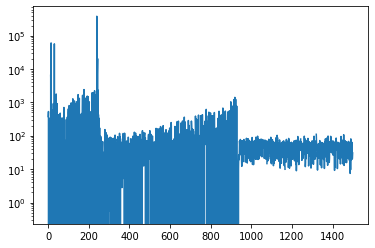

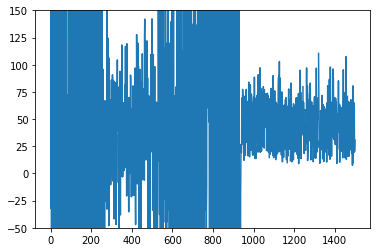


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 31.430748090147972


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 27.96618688106537


  3%|▎         | 3/100 [00:04<02:38,  1.63s/it]

2 27.539222944527864


  4%|▍         | 4/100 [00:06<02:36,  1.63s/it]

3 27.45961194112897


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 27.380707565695047


  6%|▌         | 6/100 [00:09<02:34,  1.65s/it]

5 27.243543837219477


  7%|▋         | 7/100 [00:11<02:34,  1.67s/it]

6 27.19235296919942


  8%|▊         | 8/100 [00:13<02:32,  1.66s/it]

7 27.220689356327057


  9%|▉         | 9/100 [00:14<02:30,  1.66s/it]

8 27.271565042436123


 10%|█         | 10/100 [00:16<02:29,  1.66s/it]

9 27.16327530518174


 11%|█         | 11/100 [00:18<02:25,  1.64s/it]

10 27.125561982393265


 12%|█▏        | 12/100 [00:19<02:25,  1.66s/it]

11 27.192689336836338


 13%|█▎        | 13/100 [00:21<02:25,  1.68s/it]

12 27.162919532507658


 14%|█▍        | 14/100 [00:23<02:21,  1.64s/it]

13 27.08353278040886


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 27.09537871554494


 16%|█▌        | 16/100 [00:26<02:19,  1.65s/it]

15 27.111227978020906


 17%|█▋        | 17/100 [00:28<02:15,  1.64s/it]

16 27.105205971747637


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 27.100356720387936


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 27.049072679132223


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 27.036110039800406


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 27.026373986154795


 22%|██▏       | 22/100 [00:36<02:06,  1.62s/it]

21 27.399547427892685


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 26.96771239489317


 24%|██▍       | 24/100 [00:39<02:03,  1.63s/it]

23 26.98185132816434


 25%|██▌       | 25/100 [00:41<02:03,  1.65s/it]

24 27.015547025948763


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 27.032600659877062


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 27.011740375310183


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 26.98699000477791


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 26.98887737840414


 30%|███       | 30/100 [00:49<01:53,  1.62s/it]

29 26.986677836626768


 31%|███       | 31/100 [00:50<01:53,  1.64s/it]

30 26.994559302926064


 32%|███▏      | 32/100 [00:52<01:51,  1.63s/it]

31 26.988013707101345


 33%|███▎      | 33/100 [00:54<01:49,  1.63s/it]

32 26.974317986518145


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 27.019695691764355


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 26.991749484091997


 36%|███▌      | 36/100 [00:58<01:43,  1.61s/it]

35 26.949822064489126


 37%|███▋      | 37/100 [01:00<01:40,  1.60s/it]

36 27.01940482482314


 38%|███▊      | 38/100 [01:02<01:39,  1.61s/it]

37 26.98875590786338


 39%|███▉      | 39/100 [01:03<01:37,  1.61s/it]

38 26.96767470613122


 40%|████      | 40/100 [01:05<01:36,  1.61s/it]

39 26.979380387812853


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 26.95222719758749


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 26.939196288585663


 43%|████▎     | 43/100 [01:10<01:35,  1.67s/it]

42 26.94247369468212


 44%|████▍     | 44/100 [01:12<01:34,  1.68s/it]

43 27.455670565366745


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 26.92575139924884


 46%|████▌     | 46/100 [01:15<01:29,  1.65s/it]

45 26.953996051102877


 47%|████▋     | 47/100 [01:17<01:26,  1.64s/it]

46 26.93560580909252


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 26.915674339979887


 49%|████▉     | 49/100 [01:20<01:22,  1.63s/it]

48 26.950653821229935


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 26.972627002745867


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 26.971100453287363


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

51 26.933019619435072


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 26.97305813804269


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 26.929980773478746


 55%|█████▌    | 55/100 [01:30<01:13,  1.62s/it]

54 26.936838429421186


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 26.936962489038706


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 27.002780862152576


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 26.919540729373693


 59%|█████▉    | 59/100 [01:36<01:06,  1.62s/it]

58 26.946787927299738


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 27.209279868751764


 61%|██████    | 61/100 [01:39<01:02,  1.61s/it]

60 26.881166711449623


 62%|██████▏   | 62/100 [01:41<01:01,  1.62s/it]

61 26.891642529517412


 63%|██████▎   | 63/100 [01:42<01:00,  1.63s/it]

62 26.91507249325514


 64%|██████▍   | 64/100 [01:44<00:58,  1.64s/it]

63 26.94960942491889


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 26.928269557654858


 66%|██████▌   | 66/100 [01:47<00:56,  1.65s/it]

65 26.970831405371428


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 26.89310609549284


 68%|██████▊   | 68/100 [01:51<00:53,  1.66s/it]

67 26.9091114141047


 69%|██████▉   | 69/100 [01:52<00:51,  1.66s/it]

68 26.931326020509005


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 26.933834496885538


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 26.92482865974307


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 26.938866320997477


 73%|███████▎  | 73/100 [01:59<00:44,  1.65s/it]

72 26.915178529918194


 74%|███████▍  | 74/100 [02:01<00:42,  1.65s/it]

73 26.92467650398612


 75%|███████▌  | 75/100 [02:02<00:40,  1.63s/it]

74 26.932261258363724


 76%|███████▌  | 76/100 [02:04<00:39,  1.64s/it]

75 26.951839823275805


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 26.90616011992097


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 26.89730279147625


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 26.980937507003546


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 26.900748923420906


 81%|████████  | 81/100 [02:12<00:31,  1.64s/it]

80 26.911502316594124


 82%|████████▏ | 82/100 [02:14<00:29,  1.65s/it]

81 27.82052929699421


 83%|████████▎ | 83/100 [02:15<00:28,  1.65s/it]

82 26.924732640385628


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 26.898652832955122


 85%|████████▌ | 85/100 [02:19<00:24,  1.63s/it]

84 26.900322750210762


 86%|████████▌ | 86/100 [02:20<00:22,  1.63s/it]

85 26.906231209635735


 87%|████████▋ | 87/100 [02:22<00:20,  1.61s/it]

86 26.89153379201889


 88%|████████▊ | 88/100 [02:23<00:19,  1.60s/it]

87 26.897764336317778


 89%|████████▉ | 89/100 [02:25<00:17,  1.60s/it]

88 26.923490338027477


 90%|█████████ | 90/100 [02:27<00:16,  1.61s/it]

89 26.88942576944828


 91%|█████████ | 91/100 [02:28<00:14,  1.62s/it]

90 26.95996391400695


 92%|█████████▏| 92/100 [02:30<00:13,  1.64s/it]

91 26.9106907248497


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 26.91302650421858


 94%|█████████▍| 94/100 [02:33<00:09,  1.62s/it]

93 26.926015503704548


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 26.947490096092224


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 26.9219216927886


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 26.915202870965004


 98%|█████████▊| 98/100 [02:40<00:03,  1.64s/it]

97 26.881365317851305


 99%|█████████▉| 99/100 [02:41<00:01,  1.63s/it]

98 26.94829571992159


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 26.920965041965246

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07600545138120651	

epoch 9000/10000, policy loss 0.058518052101135254	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 453.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [43]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [44]:
policy_loss_list_5 = policy_loss_list

In [45]:
with open('policy_loss_list_5.npy', 'wb') as f:
    np.save(f, policy_loss_list_5)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 6]

In [46]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 6

batch size =  50000
Config: {'ALG': 'May1_test1_th6_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 6, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

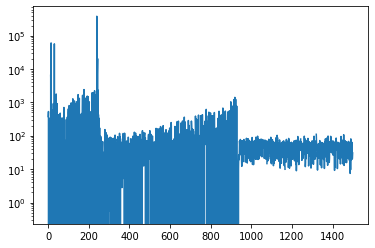

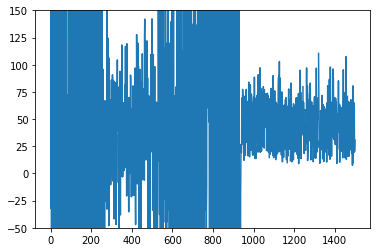


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

0 nan


  2%|▏         | 2/100 [00:02<02:25,  1.49s/it]

1 nan


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

2 nan


  4%|▍         | 4/100 [00:06<02:25,  1.51s/it]

3 nan


  5%|▌         | 5/100 [00:07<02:24,  1.52s/it]

4 nan


  6%|▌         | 6/100 [00:09<02:22,  1.52s/it]

5 nan


  7%|▋         | 7/100 [00:10<02:22,  1.54s/it]

6 nan


  8%|▊         | 8/100 [00:12<02:19,  1.52s/it]

7 nan


  9%|▉         | 9/100 [00:13<02:18,  1.52s/it]

8 nan


 10%|█         | 10/100 [00:15<02:15,  1.51s/it]

9 nan


 11%|█         | 11/100 [00:16<02:13,  1.50s/it]

10 nan


 12%|█▏        | 12/100 [00:18<02:11,  1.50s/it]

11 nan


 13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]

12 nan


 14%|█▍        | 14/100 [00:21<02:09,  1.50s/it]

13 nan


 15%|█▌        | 15/100 [00:22<02:10,  1.53s/it]

14 nan


 16%|█▌        | 16/100 [00:24<02:09,  1.54s/it]

15 nan


 17%|█▋        | 17/100 [00:25<02:10,  1.57s/it]

16 nan


 18%|█▊        | 18/100 [00:27<02:09,  1.58s/it]

17 nan


 19%|█▉        | 19/100 [00:29<02:05,  1.55s/it]

18 nan


 20%|██        | 20/100 [00:30<02:05,  1.56s/it]

19 nan


 21%|██        | 21/100 [00:32<02:03,  1.56s/it]

20 nan


 22%|██▏       | 22/100 [00:33<02:00,  1.54s/it]

21 nan


 23%|██▎       | 23/100 [00:35<01:58,  1.53s/it]

22 nan


 24%|██▍       | 24/100 [00:36<01:57,  1.55s/it]

23 nan


 25%|██▌       | 25/100 [00:38<01:57,  1.57s/it]

24 nan


 26%|██▌       | 26/100 [00:39<01:55,  1.56s/it]

25 nan


 27%|██▋       | 27/100 [00:41<01:52,  1.54s/it]

26 nan


 28%|██▊       | 28/100 [00:42<01:49,  1.52s/it]

27 nan


 29%|██▉       | 29/100 [00:44<01:47,  1.52s/it]

28 nan


 30%|███       | 30/100 [00:45<01:46,  1.52s/it]

29 nan


 31%|███       | 31/100 [00:47<01:45,  1.53s/it]

30 nan


 32%|███▏      | 32/100 [00:48<01:43,  1.51s/it]

31 nan


 33%|███▎      | 33/100 [00:50<01:42,  1.52s/it]

32 nan


 34%|███▍      | 34/100 [00:52<01:40,  1.52s/it]

33 nan


 35%|███▌      | 35/100 [00:53<01:39,  1.52s/it]

34 nan


 36%|███▌      | 36/100 [00:55<01:37,  1.53s/it]

35 nan


 37%|███▋      | 37/100 [00:56<01:36,  1.53s/it]

36 nan


 38%|███▊      | 38/100 [00:58<01:34,  1.53s/it]

37 nan


 39%|███▉      | 39/100 [00:59<01:32,  1.52s/it]

38 nan


 40%|████      | 40/100 [01:01<01:30,  1.51s/it]

39 nan


 41%|████      | 41/100 [01:02<01:28,  1.50s/it]

40 nan


 42%|████▏     | 42/100 [01:04<01:26,  1.49s/it]

41 nan


 43%|████▎     | 43/100 [01:05<01:25,  1.50s/it]

42 nan


 44%|████▍     | 44/100 [01:07<01:23,  1.49s/it]

43 nan


 45%|████▌     | 45/100 [01:08<01:22,  1.50s/it]

44 nan


 46%|████▌     | 46/100 [01:10<01:20,  1.50s/it]

45 nan


 47%|████▋     | 47/100 [01:11<01:20,  1.52s/it]

46 nan


 48%|████▊     | 48/100 [01:13<01:18,  1.51s/it]

47 nan


 49%|████▉     | 49/100 [01:14<01:18,  1.53s/it]

48 nan


 50%|█████     | 50/100 [01:16<01:17,  1.54s/it]

49 nan


 51%|█████     | 51/100 [01:17<01:15,  1.54s/it]

50 nan


 52%|█████▏    | 52/100 [01:19<01:14,  1.54s/it]

51 nan


 53%|█████▎    | 53/100 [01:20<01:12,  1.53s/it]

52 nan


 54%|█████▍    | 54/100 [01:22<01:10,  1.54s/it]

53 nan


 55%|█████▌    | 55/100 [01:23<01:08,  1.53s/it]

54 nan


 56%|█████▌    | 56/100 [01:25<01:07,  1.54s/it]

55 nan


 57%|█████▋    | 57/100 [01:27<01:07,  1.56s/it]

56 nan


 58%|█████▊    | 58/100 [01:28<01:04,  1.55s/it]

57 nan


 59%|█████▉    | 59/100 [01:30<01:02,  1.53s/it]

58 nan


 60%|██████    | 60/100 [01:31<01:00,  1.52s/it]

59 nan


 61%|██████    | 61/100 [01:33<00:58,  1.51s/it]

60 nan


 62%|██████▏   | 62/100 [01:34<00:57,  1.51s/it]

61 nan


 63%|██████▎   | 63/100 [01:36<00:56,  1.52s/it]

62 nan


 64%|██████▍   | 64/100 [01:37<00:54,  1.52s/it]

63 nan


 65%|██████▌   | 65/100 [01:39<00:53,  1.54s/it]

64 nan


 66%|██████▌   | 66/100 [01:40<00:52,  1.53s/it]

65 nan


 67%|██████▋   | 67/100 [01:42<00:50,  1.53s/it]

66 nan


 68%|██████▊   | 68/100 [01:43<00:48,  1.53s/it]

67 nan


 69%|██████▉   | 69/100 [01:45<00:47,  1.52s/it]

68 nan


 70%|███████   | 70/100 [01:46<00:45,  1.53s/it]

69 nan


 71%|███████   | 71/100 [01:48<00:43,  1.52s/it]

70 nan


 72%|███████▏  | 72/100 [01:49<00:42,  1.52s/it]

71 nan


 73%|███████▎  | 73/100 [01:51<00:41,  1.52s/it]

72 nan


 74%|███████▍  | 74/100 [01:53<00:39,  1.53s/it]

73 nan


 75%|███████▌  | 75/100 [01:54<00:38,  1.53s/it]

74 nan


 76%|███████▌  | 76/100 [01:56<00:36,  1.53s/it]

75 nan


 77%|███████▋  | 77/100 [01:57<00:35,  1.55s/it]

76 nan


 78%|███████▊  | 78/100 [01:59<00:34,  1.56s/it]

77 nan


 79%|███████▉  | 79/100 [02:00<00:32,  1.55s/it]

78 nan


 80%|████████  | 80/100 [02:02<00:30,  1.53s/it]

79 nan


 81%|████████  | 81/100 [02:03<00:29,  1.54s/it]

80 nan


 82%|████████▏ | 82/100 [02:05<00:27,  1.55s/it]

81 nan


 83%|████████▎ | 83/100 [02:06<00:25,  1.53s/it]

82 nan


 84%|████████▍ | 84/100 [02:08<00:24,  1.55s/it]

83 nan


 85%|████████▌ | 85/100 [02:10<00:23,  1.58s/it]

84 nan


 86%|████████▌ | 86/100 [02:11<00:21,  1.55s/it]

85 nan


 87%|████████▋ | 87/100 [02:13<00:20,  1.54s/it]

86 nan


 88%|████████▊ | 88/100 [02:14<00:18,  1.53s/it]

87 nan


 89%|████████▉ | 89/100 [02:16<00:16,  1.53s/it]

88 nan


 90%|█████████ | 90/100 [02:17<00:15,  1.56s/it]

89 nan


 91%|█████████ | 91/100 [02:19<00:13,  1.55s/it]

90 nan


 92%|█████████▏| 92/100 [02:20<00:12,  1.52s/it]

91 nan


 93%|█████████▎| 93/100 [02:22<00:10,  1.51s/it]

92 nan


 94%|█████████▍| 94/100 [02:23<00:09,  1.51s/it]

93 nan


 95%|█████████▌| 95/100 [02:25<00:07,  1.50s/it]

94 nan


 96%|█████████▌| 96/100 [02:26<00:06,  1.51s/it]

95 nan


 97%|█████████▋| 97/100 [02:28<00:04,  1.50s/it]

96 nan


 98%|█████████▊| 98/100 [02:29<00:03,  1.51s/it]

97 nan


 99%|█████████▉| 99/100 [02:31<00:01,  1.52s/it]

98 nan


100%|██████████| 100/100 [02:32<00:00,  1.51s/it]

99 nan

***** train student policy network *****
train in NFiVAE



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/linear.py:103: UserWarning: An output with one or more elements was resized since it had shape [989, 64], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  return F.linear(input, self.weight, self.bias)


RuntimeError: ignored

In [47]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th6_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_6 = policy_loss_list

In [ ]:
with open('policy_loss_list_6.npy', 'wb') as f:
    np.save(f, policy_loss_list_6)

In [ ]:
plt.plot(policy_loss_list_neg1, labels='Threshold >=0')
plt.plot(policy_loss_list_0, labels='Threshold >=1')
plt.plot(policy_loss_list_1, labels='Threshold >=2')
plt.plot(policy_loss_list_2, labels='Threshold >=3')
plt.plot(policy_loss_list_3, labels='Threshold >=4')
plt.plot(policy_loss_list_4, labels='Threshold >=5')
plt.plot(policy_loss_list_5, labels='Threshold >=6')
plt.plot(policy_loss_list_6, labels='Threshold >=7')



In [12]:
with open('policy_loss_list_neg1.npy', 'rb') as f:
    policy_loss_list_neg1 = np.load(f, allow_pickle = True)

In [13]:
with open('policy_loss_list_0.npy', 'rb') as f:
    policy_loss_list_0 = np.load(f, allow_pickle = True)

In [14]:
with open('policy_loss_list_1.npy', 'rb') as f:
    policy_loss_list_1 = np.load(f, allow_pickle = True)

In [15]:
with open('policy_loss_list_2.npy', 'rb') as f:
    policy_loss_list_2 = np.load(f, allow_pickle = True)

In [16]:
with open('policy_loss_list_3.npy', 'rb') as f:
    policy_loss_list_3 = np.load(f, allow_pickle = True)

In [17]:
with open('policy_loss_list_4.npy', 'rb') as f:
    policy_loss_list_4 = np.load(f, allow_pickle = True)

In [18]:
with open('policy_loss_list_5.npy', 'rb') as f:
    policy_loss_list_5 = np.load(f, allow_pickle = True)

In [43]:
policy_loss_list_neg1 = np.stack([policy_loss_list_neg1[i].cpu().numpy() for i in range(len(policy_loss_list_neg1))])

AttributeError: ignored

In [35]:
policy_loss_list_0 = np.stack([policy_loss_list_0[i].cpu().numpy() for i in range(len(policy_loss_list_0))])

AttributeError: ignored

In [36]:
policy_loss_list_1 = np.stack([policy_loss_list_1[i].cpu().numpy() for i in range(len(policy_loss_list_1))])

AttributeError: ignored

In [41]:
policy_loss_list_2 = np.stack([policy_loss_list_2[i].cpu().numpy() for i in range(len(policy_loss_list_2))])

AttributeError: ignored

In [38]:
policy_loss_list_3 = np.stack([policy_loss_list_3[i].cpu().numpy() for i in range(len(policy_loss_list_3))])

In [39]:
policy_loss_list_4 = np.stack([policy_loss_list_4[i].cpu().numpy() for i in range(len(policy_loss_list_4))])

In [40]:
policy_loss_list_5 = np.stack([policy_loss_list_5[i].cpu().numpy() for i in range(len(policy_loss_list_5))])

In [62]:
result = np.zeros((6, 10000))

In [63]:
result[0] = policy_loss_list_neg1
result[1] = policy_loss_list_1
result[2] = policy_loss_list_2
result[3] = policy_loss_list_3
result[4] = policy_loss_list_4
result[5] = policy_loss_list_5

with open('phase3loss.npy', 'wb') as f:
    np.save(f, result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


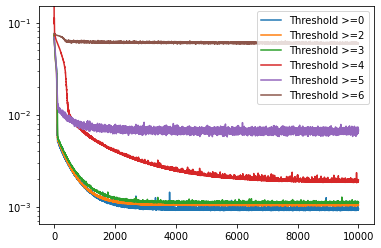

In [59]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1, label='Threshold >=0')
#plt.plot(policy_loss_list_0, label='Threshold >=1')
plt.plot(policy_loss_list_1, label='Threshold >=2')
plt.plot(policy_loss_list_2, label='Threshold >=3')
plt.plot(policy_loss_list_3, label='Threshold >=4')
plt.plot(policy_loss_list_4, label='Threshold >=5')
plt.plot(policy_loss_list_5, label='Threshold >=6')
plt.yscale("log")
plt.ylim(0,0.15)

plt.legend()
